# Tree Edit Networks

This notebook contains applications of graph edit networks (without edge actions) to trees.

## Task 1: Boolean Formula Simplification

We generate a random Boolean formula over the variables $x$ and $y$ with at most 3 binary operators and then apply simplification rules until none apply anymore. The time series is the series of iteratively simpler formulae.

In [1]:
# set up the model
import torch
import numpy as np
import pytorch_tree_edit_networks as ten

# the number of experimental repititions
R = 5
# the number of test trees
N_test = 10

# training hyperparameters
max_epochs     = 30000
learning_rate  = 1E-3
weight_decay   = 1E-5
loss_threshold = 1E-3

# model hyperparameters
num_layers = 2
dim_hid = 64
skip_connections = False
nonlin = torch.nn.ReLU()
max_degree = 4

accs = np.zeros(R)
learning_curves = []

In [ ]:
# learn
import edist.tree_utils as tu
import boolean_formulae

unique = True

for r in range(R):
    print('--- repeat %d of %d ---' % (r+1, R))
    test_set, unique_As = boolean_formulae.create_test_set(N_test)
    # instantiate network and optimizer
    net = ten.TEN(num_layers = num_layers, alphabet = boolean_formulae.alphabet,
                  dim_hid = dim_hid, skip_connections = skip_connections, nonlin = nonlin,
                  dim_in_extra = max_degree + 1)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # start training
    loss_avg = None
    learning_curve = []
    epochs = 0
    while epochs < max_epochs:
        optimizer.zero_grad()
        # sample a nontrivial time series
        if unique:
            time_series = boolean_formulae.generate_unique_time_series(test_set)
        else:
            time_series = boolean_formulae.generate_time_series()
        if len(time_series) < 2:
            continue
        # compute the prediction loss
        loss = boolean_formulae.compute_loss(net, time_series)
        # compute the gradient
        loss.backward()
        # perform an optimizer step
        optimizer.step()
        # compute a new moving average over the loss
        if loss_avg is None:
            loss_avg = loss.item()
        else:
            loss_avg = loss_avg * 0.9 + 0.1 * loss.item()
        learning_curve.append(loss.item())
        if((epochs+1) % 100 == 0):
            print('loss avg after %d epochs: %g' % (epochs+1, loss_avg))
        epochs += 1
        if loss_avg < loss_threshold:
            break
    learning_curves.append(learning_curve)
    # after training is completed, evaluate
    j = 0
    T = 0
    while j < N_test:
        # sample a random time series
        if unique:
            time_series = test_set[j]
        else:
            time_series = boolean_formulae.generate_time_series()
        if len(time_series) < 2:
            continue
        # iterate over the time series
        for t in range(len(time_series)-1):
            # perform the prediction
            nodes, adj = time_series[t]
            try:
                _, nodes_actual, adj_actual = boolean_formulae.predict_step(net, nodes, adj)
                nodes_expected, adj_expected = time_series[t+1]
                if nodes_actual == nodes_expected and adj_actual == adj_expected:
                    accs[r] += 1
                else:
                    print('expected tree %s but was actually %s' % (tu.tree_to_string(nodes_expected, adj_expected), tu.tree_to_string(nodes_actual, adj_actual)))
            except Exception as ex:
                try:
                    boolean_formulae.predict_step(net, nodes, adj, verbose = True)
                except Exception as ex2:
                    pass
                print('Exception for input tree %s and network output %s\nexception was %s' % (tu.tree_to_string(nodes, adj, indent = True, with_indices = True), deltaX, str(ex)))
        T += len(time_series)-1
        j += 1
    accs[r] /= T
    print('accuracy: %g' % accs[r])

--- repeat 1 of 5 ---


In [ ]:
# print results
print('Accuracy: %g +- %g' % (np.mean(accs), np.std(accs)))
num_epochs = np.array(list(map(len, learning_curves)))
print('Epochs: %g +- %g' % (np.mean(num_epochs), np.std(num_epochs)))

In [ ]:
# visualize learning curves
import matplotlib.pyplot as plt
smoothing_steps = 10
for r in range(R):
    # compute a moving average before visualization
    acum = np.cumsum(learning_curves[r])
    plt.semilogy((acum[smoothing_steps:] - acum[:-smoothing_steps])/smoothing_steps)
plt.show()

## Task 2: Addition

We generate an addition formula of at most four numbers in the range 1-3 and then use the Peano addition axiom to compute the addition. In particular, the following four rules apply.

1. +(m, 0) for any m can be replaced with m.
2. +(m, succ(n)) can be replaced with succ(+(m, n)).
3. +(m, n) for n in the range 0-9 can be replaced with +(m, succ(n-1)) where -1 refers to the numeric subtraction of 1.
4. succ(n) for n in the range 0-9 can be replaced with n+1 (mod 10 because we don't permit two-digit numbers).

A time series arises by applying to a current tree every rule that is applicable until a tree results which is only a single number.

In [1]:
# set up the model
import torch
import numpy as np
import pytorch_tree_edit_networks as ten

# the number of experimental repititions
R = 5
# the number of test trees
N_test = 10

# training hyperparameters
max_epochs     = 30000
learning_rate  = 1E-3
weight_decay   = 1E-5
loss_threshold = 1E-3

# model hyperparameters
# a single layer with sufficient neurons should suffice here, because we only need to
# check immediate parents and children to check whether a rule applies
num_layers = 2
dim_hid = 64
skip_connections = False
nonlin = torch.nn.ReLU()
max_degree = 2

accs = np.zeros(R)
learning_curves = []

In [2]:
# learn
import edist.tree_utils as tu
import peano_addition

for r in range(R):
    print('--- repeat %d of %d ---' % (r+1, R))
    # instantiate network and optimizer
    net = ten.TEN(num_layers = num_layers, alphabet = peano_addition.alphabet,
                  dim_hid = dim_hid, skip_connections = skip_connections, nonlin = nonlin,
                  dim_in_extra = max_degree + 1)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # start training
    loss_avg = None
    learning_curve = []
    epochs = 0
    while epochs < max_epochs:
        optimizer.zero_grad()
        # sample a nontrivial time series
        time_series = peano_addition.generate_time_series()
        if len(time_series) < 2:
            continue
        # compute the prediction loss
        loss = peano_addition.compute_loss(net, time_series)
        # compute the gradient
        loss.backward()
        # perform an optimizer step
        optimizer.step()
        # compute a new moving average over the loss
        if loss_avg is None:
            loss_avg = loss.item()
        else:
            loss_avg = loss_avg * 0.9 + 0.1 * loss.item()
        learning_curve.append(loss.item())
        if((epochs+1) % 100 == 0):
            print('loss avg after %d epochs: %g' % (epochs+1, loss_avg))
        epochs += 1
        if loss_avg < loss_threshold:
            break
    learning_curves.append(learning_curve)
    # after training is completed, evaluate
    j = 0
    T = 0
    while j < N_test:
        # sample a random time series
        time_series = peano_addition.generate_time_series()
        if len(time_series) < 2:
            continue
        # iterate over the time series
        for t in range(len(time_series)-1):
            # perform the prediction
            nodes, adj = time_series[t]
            try:
                _, nodes_actual, adj_actual = peano_addition.predict_step(net, nodes, adj)
                nodes_expected, adj_expected = time_series[t+1]
                if nodes_actual == nodes_expected and adj_actual == adj_expected:
                    accs[r] += 1
                else:
                    print('expected tree %s but was actually %s' % (tu.tree_to_string(nodes_expected, adj_expected), tu.tree_to_string(nodes_actual, adj_actual)))
            except Exception as ex:
                try:
                    peano_addition.predict_step(net, nodes, adj, verbose = True)
                except Exception as ex2:
                    pass
                print('Exception for input tree %s and network output %s\nexception was %s' % (tu.tree_to_string(nodes, adj, indent = True, with_indices = True), deltaX, str(ex)))
        T += len(time_series)-1
        j += 1
    accs[r] /= T
    print('accuracy: %g' % accs[r])

--- repeat 1 of 5 ---
loss avg after 100 epochs: 412.88
loss avg after 200 epochs: 188.633
loss avg after 300 epochs: 108.75
loss avg after 400 epochs: 83.5314
loss avg after 500 epochs: 39.0241
loss avg after 600 epochs: 28.1514
loss avg after 700 epochs: 35.2105
loss avg after 800 epochs: 15.8604
loss avg after 900 epochs: 13.0377
loss avg after 1000 epochs: 7.27475
loss avg after 1100 epochs: 7.44812
loss avg after 1200 epochs: 3.56508
loss avg after 1300 epochs: 2.90106
loss avg after 1400 epochs: 2.30318
loss avg after 1500 epochs: 1.77996
loss avg after 1600 epochs: 1.60777
loss avg after 1700 epochs: 1.69116
loss avg after 1800 epochs: 1.51791
loss avg after 1900 epochs: 1.08536
loss avg after 2000 epochs: 1.07082
loss avg after 2100 epochs: 0.897198
loss avg after 2200 epochs: 0.626463
loss avg after 2300 epochs: 0.485799
loss avg after 2400 epochs: 0.471478
loss avg after 2500 epochs: 0.611787
loss avg after 2600 epochs: 0.468785
loss avg after 2700 epochs: 0.379
loss avg afte

In [3]:
# print results
print('Accuracy: %g +- %g' % (np.mean(accs), np.std(accs)))
num_epochs = np.array(list(map(len, learning_curves)))
print('Epochs: %g +- %g' % (np.mean(num_epochs), np.std(num_epochs)))

Accuracy: 1 +- 0
Epochs: 12768.4 +- 933.092


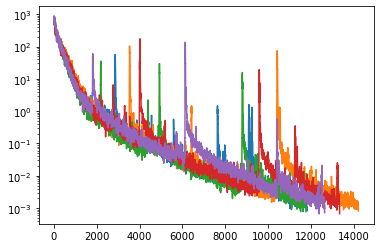

In [4]:
# visualize learning curves
import matplotlib.pyplot as plt
smoothing_steps = 10
for r in range(R):
    # compute a moving average before visualization
    acum = np.cumsum(learning_curves[r])
    plt.semilogy((acum[smoothing_steps:] - acum[:-smoothing_steps])/smoothing_steps)
plt.show()